# Exploring color space

[Roch et al.](https://s3-eu-west-1.amazonaws.com/itempdf74155353254prod/5953606/ChemOS__An_Orchestration_Software_to_Democratize_Autonomous_Discovery_v1.pdf) described an experiment in which they used an autonomous laboratory to explore color space. More specifically, given five colored dyes of unknown color, and a robot that could mix different quantities of up to three of dyes and then measure the color of the result, they sought to identify a combination of dyes that would give a good match to a target color.

We hope to run such experiments in a physical laboratory. First, however, we have two Python functions that will approximate the behavior of a real experiment:

1.   **color_mixture**(c1, f1, c2, f2, c3, f3): Given three RGB colors and their fractions (each ≥0, summing to 1), return the RGB color of the resulting mixture.

2.   **color_diff**(c1, c2): Given two RGB colors, return a measure of the difference between them.

We’ll use these two functions as our experimental laboratory.

Your task is to write a Python program that when given a list of five RGB dyes and a target color will use as few experiments as possible to obtain the combination of three dyes that best approximates the target. We'll evaluate solutions in two ways:

1. The quality of the best color combination found for a specified experiment budget (10 experiments, 100, ...)

2. The number of experiments to find a combination of colors with difference less than a specified threshold

We implement below a naive uniform sampling search. 
It's not too hard to do better than that. Let's see who does the best!

We'll provide details soon on how to submit solutions.

In [2]:
import imageio
import matplotlib.pyplot as plt
import random

!pip install colormath
# https://python-colormath.readthedocs.io/en/latest/color_objects.html
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import decimal
import itertools

  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=d2e5af93742d07fe83a55af4e5ce2b4c5537d110c2130d73645ff581ac79e4df
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


## Some utility functions

In [3]:
red   = sRGBColor(1.0, 0.0, 0.0) #Defines the different colors 
green = sRGBColor(0.0, 1.0, 0.0)
blue  = sRGBColor(0.0, 0.0, 1.0)

def random_color(): # Gets a random color
    color = sRGBColor(random.random(), random.random(), random.random())
    return(color)

def show_colors(colors): # calls function after
    show_colors_at_width(0.5, colors)

def show_colors_at_width(width, colors): #Takes a width and a color to return color image
    num_colors = len(colors)
    size = width/num_colors
    fig, ax = plt.subplots(figsize=(num_colors*width,width))
    ax.plot([0,width], [0,0.2*width], color='w', alpha=0)
    ax.set_xlim([0,width])
    ax.set_ylim([0,size])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(False)

    for c, i in zip(colors, range(num_colors)):
        ax.add_patch( patches.Rectangle((i*size, 0),   size, size, facecolor = c.get_rgb_hex()) )
    plt.show()

In [4]:
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

## Our experimental lab supports mixing and color differencing

In [5]:
def combine_colors(color1, f1, color2, f2, color3, f3):
    #if f1<0 or f1>1.0 or f2<0 or f2>1.0 or f3<0 or f3>1.0 or f1+f2+f3!=1.0:
    #    print(f'Bad fractions: {f1}, {f2}, {f3}')
    #    return(-1)
    (r1, g1, b1) = color1.get_value_tuple()
    (r2, g2, b2) = color2.get_value_tuple()
    (r3, g3, b3) = color3.get_value_tuple()
    new_color = sRGBColor(r1*f1 + r2*f2 + r3*f3, g1*f1 + g2*f2 + g3*f3, b1*f1 + b2*f2 + b3*f3)
    return new_color

# See https://dev.to/tejeshreddy/color-difference-between-2-colours-using-python-182b
def color_diff(color1_rgb, color2_rgb):
    color1_lab = convert_color(color1_rgb, LabColor)
    color2_lab = convert_color(color2_rgb, LabColor)
    delta_e = delta_e_cie2000(color1_lab, color2_lab)
    return(delta_e)

## A naive uniform sampling strategy

In [6]:
def uniform_sampling(target, colors, number):
    best_color = None
    best_diff  = -1
    increment  = 1.0/number
    for [color1, color2, color3] in itertools.combinations(colors, 3):
        for i in drange(0, 1, increment):
            for j in drange(0, 1-i, increment):
                k = 1.0-i-j
                mix  = combine_colors(color1, i, color2, j, color3, k)
                diff = color_diff(target, mix)
                if diff < best_diff or best_diff < 0:
                    best_diff = diff
                    best_color = (mix, color1, i, color2, j, color3, k, mix)
                    #print(f'{round(i,3)}, {round(j,3)}, {round(k,3)} with diff {round(best_diff,3)}')
                
    return(best_diff, best_color)

### A simple example that you can surely improve on: it uses a lot of experiments to find a combination with a difference of 8.3

Target, three colors (0.0, 0.39, 0.61), mix with diff 8.29:


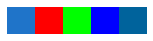

In [ ]:
colors = [red, green, blue]
target = sRGBColor(0.123, 0.456, 0.789)

(best_diff, (best, color1, f1, color2, f2, color3, f3, mix)) = uniform_sampling(target, colors, 100)

print(f'Target, three colors ({round(f1,3)}, {round(f2,3)}, {round(f3,3)}), mix with diff {round(best_diff,2)}:')
show_colors([target, color1, color2, color3, mix])

## Your mission: Implement a better sampling strategy 


## I am using the *SciPy* optimizer module for this task.

In [7]:
import scipy
from scipy.optimize import minimize

## Constraints on the optimization: 

* The sum of the three ratios has to equal 1
* Each ratio has to be a non-negative number
* Each ratio has to be less than or equal to 1

The constraints are defined below to be passed onto the minimize module

In [8]:
#Constraints for the optimizer.

constraints = [
        #Constraint 1
        {'type': 'eq', 'fun' : lambda x : (x[0] + x[1] + x[2]) - 1.0}, 

        #Constraint 2 
        {'type': 'ineq', 'fun' : lambda x : x[0]}, 

        {'type': 'ineq', 'fun' : lambda x : x[1]},
        {'type': 'ineq', 'fun' : lambda x : x[2]},

        #Constraint 3 
        {'type': 'ineq', 'fun' : lambda x : 1.0- x[0]},   
        {'type': 'ineq', 'fun' : lambda x : 1.0 - x[1]},
        {'type': 'ineq', 'fun' : lambda x : 1.0 - x[2]},
]


##Objective/Loss function:

In [9]:
# Takes in the colors (tuple) to be mixed and their ratios (array), and compares it to the target color (sRGBColor object) through color_diff method
def objective_func(mixing_ratios, mixing_colors, target):
  combination = combine_colors(mixing_colors[0], mixing_ratios[0], mixing_colors[1], mixing_ratios[1], mixing_colors[2], mixing_ratios[2])
  difference = color_diff(combination, target)
  return difference

##Optimization Loop for Part 1

In [10]:
def optimization_loop_part_one(target, colors, maximum_iterations):
  '''
  Takes:
    Target color
    Five colors to mix
    Maximum number of iterations to go through

  Returns:
    Distance between target color and best color the method found
    Best triplet colors and their ratios
    Best color that's compared to the target
    Number of iterations it took to find the best color

  '''

  best_triplet_iters = 0
  total_iters = 0 
  best_diff = -1
  best_colors = None
  best_ratios = None

  for [color1, color2 ,color3] in itertools.combinations(colors, 3):
    #initial dummy guess. 
    initial_ratios = [random.random(), random.random(), random.random()]

    #call to the scipy.optimize.minimize function to use the Sequential Least Squares algorithm.
    result = minimize(objective_func,
                      initial_ratios,
                      args=([color1, color2, color3], target), 
                      constraints = constraints, 
                      method='SLSQP', #Sequential Least Squares
                      options = {'maxiter': maximum_iterations/6})
    

    #If this triplet mixes closest to the target, then they are the best triplet. 
    if result.fun < best_diff or best_diff == -1 :
      best_diff = result.fun  
      best_colors = [color1, color2, color3]
      best_ratios = result.x 
      best_triplet_iters = result.nfev

    total_iters += result.nfev


  return (best_diff, (best_colors[0], best_ratios[0],
                      best_colors[1], best_ratios[1],
                      best_colors[2], best_ratios[2]), 
          
                      combine_colors(
                          best_colors[0], best_ratios[0],
                          best_colors[1], best_ratios[1],
                          best_colors[2], best_ratios[2]), 
          
          best_triplet_iters)

## Another test to try: Use a random set of colors

Available colors:


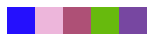

Target, three colors (-0.0, -0.0, 1.0), mix with difference 7.15:


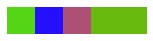

In [ ]:
colors = [random_color(), random_color(), random_color(), random_color(), random_color()]
target = random_color()

print('Available colors:')
show_colors(colors)

(best_diff, (color1, f1, color2, f2, color3, f3), mix, iters) = optimization_loop_part_one(target, colors, 100)

print(f'Target, three colors ({round(f1,3)}, {round(f2,3)}, {round(f3,3)}), mix with difference {round(best_diff,2)}:')
show_colors([target, color1, color2, color3, mix])

##Part 1: Finding the best color in N iterations

In [37]:
import numpy as np

def task_one_wrapper(max_iter, num_experiments_to_average):
  my_best_distances = []
  benchmark_distances = []
  my_iteration_count = []
  benchmark_iteration_count = []

  for i in range(num_experiments_to_average):
    print(f"Experiment {i+1}  \n")

    random.seed(random.randint(0, 25))
    color_options = [random_color(), random_color(), random_color(), random_color(), random_color()]
    target_color = random_color()

    print('Available 5 colors:')
    show_colors(color_options)

    best_diff, triplet_and_ratios, best_mix, num_iters = optimization_loop_part_one(target_color, color_options, max_iter)
    my_best_distances.append(best_diff)
    my_iteration_count.append(num_iters)

    print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
    print(f'Best difference: {round(best_diff,3)} ')
    print(f'Number of iterations: {num_iters}')
    print(f'Plot: target color, three best colors, closest mix (result)' )
    show_colors([target_color, triplet_and_ratios[0], triplet_and_ratios[2], triplet_and_ratios[4], best_mix])

    

    print('--------------------------------')
  
  print (f"Average Distance after {max_iter} is {round(np.mean(my_best_distances), 2)}")
  

## Experiment Budget : 10 

Experiment 1  

Available 5 colors:


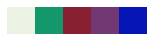

Optimum mix ratios 0.552, 0.056, 0.31 
Best difference: 8.782 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


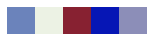

--------------------------------
Experiment 2  

Available 5 colors:


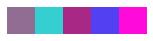

Optimum mix ratios 1.0, -0.0, 0.0 
Best difference: 25.549 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


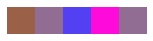

--------------------------------
Experiment 3  

Available 5 colors:


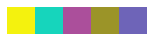

Optimum mix ratios 0.672, 0.454, 0.449 
Best difference: 8.868 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


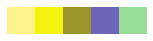

--------------------------------
Experiment 4  

Available 5 colors:


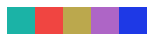

Optimum mix ratios -0.0, 0.529, 0.471 
Best difference: 4.494 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


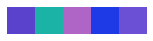

--------------------------------
Experiment 5  

Available 5 colors:


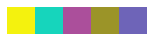

Optimum mix ratios 0.672, 0.454, 0.449 
Best difference: 8.868 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


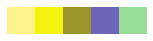

--------------------------------
Experiment 6  

Available 5 colors:


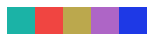

Optimum mix ratios -0.0, 0.529, 0.471 
Best difference: 4.494 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


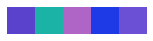

--------------------------------
Experiment 7  

Available 5 colors:


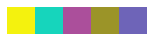

Optimum mix ratios 0.672, 0.454, 0.449 
Best difference: 8.868 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


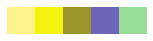

--------------------------------
Experiment 8  

Available 5 colors:


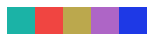

Optimum mix ratios -0.0, 0.529, 0.471 
Best difference: 4.494 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


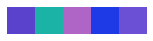

--------------------------------
Experiment 9  

Available 5 colors:


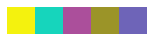

Optimum mix ratios 0.672, 0.454, 0.449 
Best difference: 8.868 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


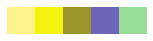

--------------------------------
Experiment 10  

Available 5 colors:


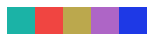

Optimum mix ratios -0.0, 0.529, 0.471 
Best difference: 4.494 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


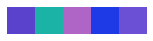

--------------------------------
Average Distance after 10 is 8.78


In [38]:
task_one_wrapper(10, 10)

##Experiment budget: 50

Experiment 1  

Available 5 colors:


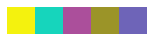

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


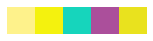

--------------------------------
Experiment 2  

Available 5 colors:


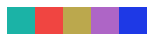

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


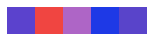

--------------------------------
Experiment 3  

Available 5 colors:


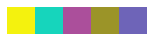

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


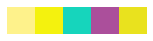

--------------------------------
Experiment 4  

Available 5 colors:


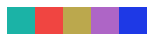

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


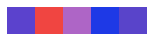

--------------------------------
Experiment 5  

Available 5 colors:


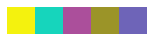

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


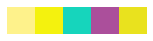

--------------------------------
Experiment 6  

Available 5 colors:


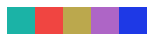

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


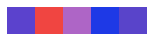

--------------------------------
Experiment 7  

Available 5 colors:


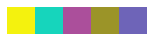

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


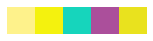

--------------------------------
Experiment 8  

Available 5 colors:


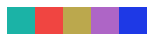

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


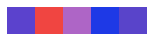

--------------------------------
Experiment 9  

Available 5 colors:


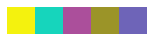

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


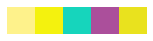

--------------------------------
Experiment 10  

Available 5 colors:


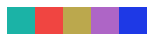

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


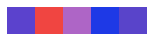

--------------------------------
Average Distance after 50 is 4.91


In [39]:
task_one_wrapper(50, 10)

##Experiment budget: 100

Experiment 1  

Available 5 colors:


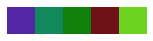

Optimum mix ratios 0.565, 0.152, 0.283 
Best difference: 25.151 
Number of iterations: 55
Plot: target color, three best colors, closest mix (result)


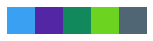

--------------------------------
Experiment 2  

Available 5 colors:


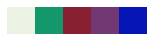

Optimum mix ratios 0.428, 0.116, 0.456 
Best difference: 0.839 
Number of iterations: 57
Plot: target color, three best colors, closest mix (result)


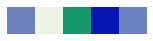

--------------------------------
Experiment 3  

Available 5 colors:


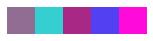

Optimum mix ratios 1.0, 0.0, -0.0 
Best difference: 25.549 
Number of iterations: 15
Plot: target color, three best colors, closest mix (result)


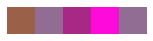

--------------------------------
Experiment 4  

Available 5 colors:


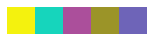

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


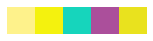

--------------------------------
Experiment 5  

Available 5 colors:


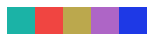

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


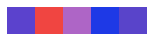

--------------------------------
Experiment 6  

Available 5 colors:


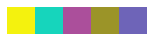

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


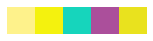

--------------------------------
Experiment 7  

Available 5 colors:


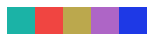

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


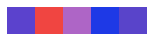

--------------------------------
Experiment 8  

Available 5 colors:


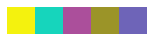

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


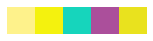

--------------------------------
Experiment 9  

Available 5 colors:


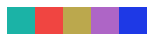

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


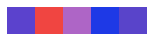

--------------------------------
Experiment 10  

Available 5 colors:


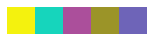

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


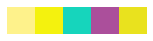

--------------------------------
Average Distance after 100 is 9.01


In [45]:
task_one_wrapper(100, 10)

## Experiment budget: 1000

Experiment 1  

Available 5 colors:


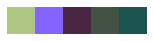

Optimum mix ratios 0.326, -0.0, 0.674 
Best difference: 20.952 
Number of iterations: 37
Plot: target color, three best colors, closest mix (result)


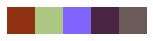

--------------------------------
Experiment 2  

Available 5 colors:


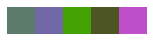

Optimum mix ratios -0.0, -0.0, 1.0 
Best difference: 9.051 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


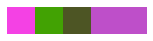

--------------------------------
Experiment 3  

Available 5 colors:


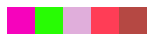

Optimum mix ratios -0.0, 0.25, 0.75 
Best difference: 22.601 
Number of iterations: 59
Plot: target color, three best colors, closest mix (result)


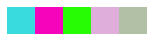

--------------------------------
Experiment 4  

Available 5 colors:


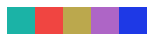

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


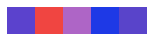

--------------------------------
Experiment 5  

Available 5 colors:


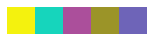

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


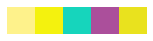

--------------------------------
Experiment 6  

Available 5 colors:


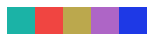

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


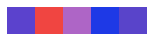

--------------------------------
Experiment 7  

Available 5 colors:


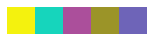

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


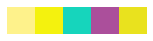

--------------------------------
Experiment 8  

Available 5 colors:


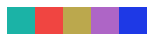

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


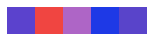

--------------------------------
Experiment 9  

Available 5 colors:


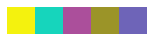

Optimum mix ratios 0.892, 0.017, 0.091 
Best difference: 9.086 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


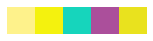

--------------------------------
Experiment 10  

Available 5 colors:


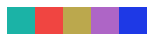

Optimum mix ratios 0.128, 0.225, 0.647 
Best difference: 0.739 
Number of iterations: 49
Plot: target color, three best colors, closest mix (result)


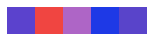

--------------------------------
Average Distance after 1000 is 8.28


In [52]:
random.seed(random.randint(0,100))
task_one_wrapper(1000, 10)

##Part 2: Number of Iterations Needed to Reach a Specified Threshold of Distance

In [53]:
def is_threshold_met(xk, state):
  '''
  Callback method passed to the scipy.optimize.minimize function.
  Stops the execution of the optimization loop once the threshold is met.
  state object is passed to this function by the minimize function.
  state.fun holds the current value of the objective function that is being minimized.
  '''

  #If the color distance reached below the threshold, then stop execution.
  if(state.fun <= THRESHOLD):
    return True


In [54]:
#Optimization loop. 
def optimization_loop_part_two(target, colors):
    best_diff = -1  
    best_colors = None
    best_ratios = None
    iters = 0

    for [c1, c2, c3] in itertools.combinations(colors, 3): 
      #initial dummy guess. 
      initial_ratios = [random.random(), random.random(), random.random()]

      #Using the Trust Regions Method from SciPy Optimize module because this is the only method that can take a callback.
      #Callback stops the optimization (distance minimization) when the call returns True, which it does when the objective function...
      #...returns a value below the threshold.

      result = minimize(objective_func,
                      initial_ratios,
                      args=([c1, c2, c3], target), 
                      constraints = constraints, 
                      method='trust-constr', #Trust Regions Method
                      callback= is_threshold_met)
      
      if (result.fun < best_diff or best_diff == -1):
        best_diff = result.fun
        best_colors = [c1, c2, c3]
        best_ratios = result.x
        iters = result.nfev # iterations it took to satisfy the contion.

        

    return ( best_diff, (best_colors[0], best_ratios[0],
                         best_colors[1], best_ratios[1],
                         best_colors[2], best_ratios[2]),
            
                         combine_colors(best_colors[0], best_ratios[0],
                                        best_colors[1], best_ratios[1], 
                                        best_colors[2], best_ratios[2]) , 
            
            iters)

In [56]:
import numpy as np
def task_two_wrapper(num_experiments_to_average):
  
  my_best_distances = []
  my_iteration_count = []

  for i in range(num_experiments_to_average):
    random.seed(i*i)
    print(f"Experiment {i+1}  \n")
    color_options = [random_color(), random_color(), random_color(), random_color(), random_color()]
    target_color = random_color()

    print('Available 5 colors:')
    show_colors(color_options)

    best_diff, triplet_and_ratios, best_mix, num_iters = optimization_loop_part_two(target_color, color_options)
    my_best_distances.append(best_diff)
    my_iteration_count.append(num_iters)

    if(round(best_diff, 3) <= THRESHOLD):
      print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
      print(f'Best difference: {round(best_diff,3)}')
      print(f'Satisfied threshold after {num_iters} of iterations!')
    
    else:
      print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
      print(f'Best difference: {round(best_diff,3)} ')
      print(f'Failed to meet the threshold with the given colors. Attemps: {num_iters}')


    print(f'Plot: target color, three best colors, closest mix (result)' )
    show_colors([target_color, triplet_and_ratios[0], triplet_and_ratios[2], triplet_and_ratios[4], best_mix])

    print('--------------------------------')
  

##Threshold = 30.0

Experiment 1  

Available 5 colors:


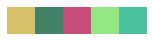

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimum mix ratios 0.668, 0.001, 0.494 
Best difference: 22.971
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


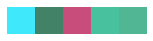

--------------------------------
Experiment 2  

Available 5 colors:


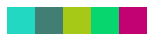

Optimum mix ratios 0.121, 0.333, 0.721 
Best difference: 19.186
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


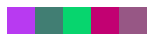

--------------------------------
Experiment 3  

Available 5 colors:


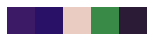

Optimum mix ratios 0.059, 0.859, 0.119 
Best difference: 8.056
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


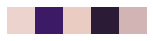

--------------------------------
Experiment 4  

Available 5 colors:


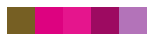

Optimum mix ratios 0.962, 0.035, 0.004 
Best difference: 24.59
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


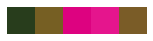

--------------------------------
Experiment 5  

Available 5 colors:


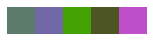

Optimum mix ratios 0.066, 0.699, 0.728 
Best difference: 12.929
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


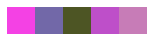

--------------------------------
Experiment 6  

Available 5 colors:


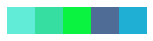

Optimum mix ratios 0.221, 0.424, 0.56 
Best difference: 13.055
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


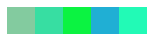

--------------------------------
Experiment 7  

Available 5 colors:


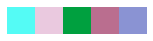

Optimum mix ratios -0.01, 0.714, 0.297 
Best difference: 14.86
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


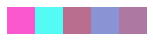

--------------------------------
Experiment 8  

Available 5 colors:


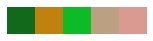

Optimum mix ratios 0.295, -0.0, 0.669 
Best difference: 26.233
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


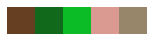

--------------------------------
Experiment 9  

Available 5 colors:


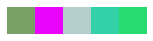

Optimum mix ratios 0.046, 0.589, 0.219 
Best difference: 6.629
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


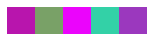

--------------------------------
Experiment 10  

Available 5 colors:


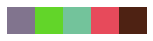

Optimum mix ratios 0.565, -0.027, 0.468 
Best difference: 17.78
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


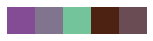

--------------------------------


In [22]:
THRESHOLD = 30.0
task_two_wrapper(10)

## Medium Case: Threshold = 20.0

Experiment 1  

Available 5 colors:


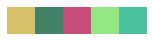

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimum mix ratios 0.0, 0.088, 0.912 
Best difference: 20.861 
Failed to meet the threshold with the given colors. Attemps: 4060
Plot: target color, three best colors, closest mix (result)


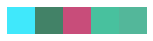

--------------------------------
Experiment 2  

Available 5 colors:


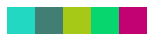

Optimum mix ratios 0.284, 0.019, 0.688 
Best difference: 17.413
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


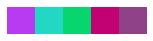

--------------------------------
Experiment 3  

Available 5 colors:


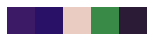

Optimum mix ratios 0.002, 0.951, 0.047 
Best difference: 3.869
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


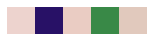

--------------------------------
Experiment 4  

Available 5 colors:


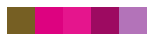

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 22.86 
Failed to meet the threshold with the given colors. Attemps: 40
Plot: target color, three best colors, closest mix (result)


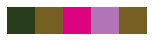

--------------------------------
Experiment 5  

Available 5 colors:


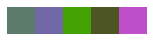

Optimum mix ratios 0.066, 0.699, 0.728 
Best difference: 12.929
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


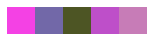

--------------------------------
Experiment 6  

Available 5 colors:


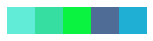

Optimum mix ratios 0.166, 0.471, 0.377 
Best difference: 10.102
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


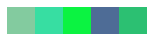

--------------------------------
Experiment 7  

Available 5 colors:


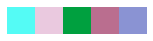

Optimum mix ratios 0.001, 0.917, 0.258 
Best difference: 12.321
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


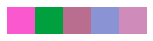

--------------------------------
Experiment 8  

Available 5 colors:


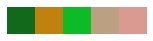

Optimum mix ratios 0.285, 0.715, 0.0 
Best difference: 26.752 
Failed to meet the threshold with the given colors. Attemps: 4052
Plot: target color, three best colors, closest mix (result)


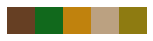

--------------------------------
Experiment 9  

Available 5 colors:


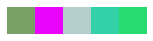

Optimum mix ratios 0.046, 0.589, 0.219 
Best difference: 6.629
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


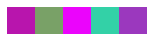

--------------------------------
Experiment 10  

Available 5 colors:


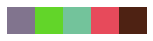

Optimum mix ratios 0.722, 0.002, 0.277 
Best difference: 15.639
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


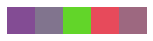

--------------------------------


In [23]:
THRESHOLD = 20.0
task_two_wrapper(10)

## Hard Case: Threshold = 10.0

Experiment 1  

Available 5 colors:


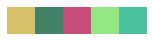

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimum mix ratios 0.0, 0.088, 0.912 
Best difference: 20.861 
Failed to meet the threshold with the given colors. Attemps: 4060
Plot: target color, three best colors, closest mix (result)


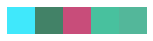

--------------------------------
Experiment 2  

Available 5 colors:


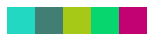

Optimum mix ratios 0.354, 0.0, 0.646 
Best difference: 16.586 
Failed to meet the threshold with the given colors. Attemps: 60
Plot: target color, three best colors, closest mix (result)


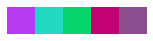

--------------------------------
Experiment 3  

Available 5 colors:


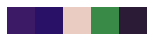

Optimum mix ratios 0.011, 0.002, 0.987 
Best difference: 2.672
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


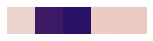

--------------------------------
Experiment 4  

Available 5 colors:


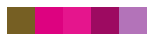

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 22.86 
Failed to meet the threshold with the given colors. Attemps: 40
Plot: target color, three best colors, closest mix (result)


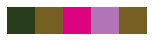

--------------------------------
Experiment 5  

Available 5 colors:


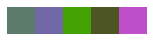

Optimum mix ratios -0.106, 0.609, 0.931 
Best difference: 8.373
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


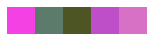

--------------------------------
Experiment 6  

Available 5 colors:


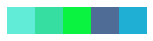

Optimum mix ratios 0.848, 0.15, 0.002 
Best difference: 7.131
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


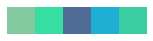

--------------------------------
Experiment 7  

Available 5 colors:


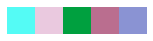

Optimum mix ratios 0.146, 0.0, 0.854 
Best difference: 14.467 
Failed to meet the threshold with the given colors. Attemps: 348
Plot: target color, three best colors, closest mix (result)


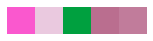

--------------------------------
Experiment 8  

Available 5 colors:


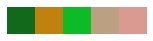

Optimum mix ratios 0.285, 0.715, 0.0 
Best difference: 26.752 
Failed to meet the threshold with the given colors. Attemps: 4052
Plot: target color, three best colors, closest mix (result)


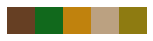

--------------------------------
Experiment 9  

Available 5 colors:


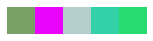

Optimum mix ratios 0.046, 0.589, 0.219 
Best difference: 6.629
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


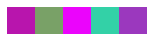

--------------------------------
Experiment 10  

Available 5 colors:


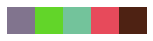

Optimum mix ratios 0.826, 0.016, 0.158 
Best difference: 14.45 
Failed to meet the threshold with the given colors. Attemps: 4004
Plot: target color, three best colors, closest mix (result)


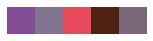

--------------------------------


In [57]:
THRESHOLD = 10.0
task_two_wrapper(10)

##Threshold = 5

Experiment 1  

Available 5 colors:


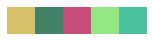

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimum mix ratios 0.0, 0.088, 0.912 
Best difference: 20.861 
Failed to meet the threshold with the given colors. Attemps: 4060
Plot: target color, three best colors, closest mix (result)


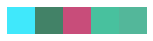

--------------------------------
Experiment 2  

Available 5 colors:


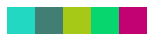

Optimum mix ratios 0.354, 0.0, 0.646 
Best difference: 16.586 
Failed to meet the threshold with the given colors. Attemps: 60
Plot: target color, three best colors, closest mix (result)


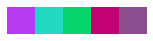

--------------------------------
Experiment 3  

Available 5 colors:


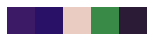

Optimum mix ratios 0.011, 0.002, 0.987 
Best difference: 2.672
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


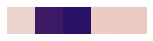

--------------------------------
Experiment 4  

Available 5 colors:


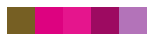

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 22.86 
Failed to meet the threshold with the given colors. Attemps: 40
Plot: target color, three best colors, closest mix (result)


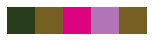

--------------------------------
Experiment 5  

Available 5 colors:


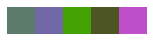

Optimum mix ratios 0.0, 0.0, 1.0 
Best difference: 9.051 
Failed to meet the threshold with the given colors. Attemps: 40
Plot: target color, three best colors, closest mix (result)


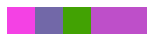

--------------------------------
Experiment 6  

Available 5 colors:


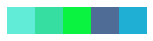

Optimum mix ratios 0.467, 0.268, 0.265 
Best difference: 6.419 
Failed to meet the threshold with the given colors. Attemps: 332
Plot: target color, three best colors, closest mix (result)


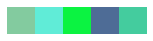

--------------------------------
Experiment 7  

Available 5 colors:


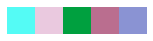

Optimum mix ratios 0.146, 0.0, 0.854 
Best difference: 14.467 
Failed to meet the threshold with the given colors. Attemps: 348
Plot: target color, three best colors, closest mix (result)


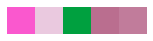

--------------------------------
Experiment 8  

Available 5 colors:


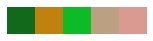

Optimum mix ratios 0.285, 0.715, 0.0 
Best difference: 26.752 
Failed to meet the threshold with the given colors. Attemps: 4052
Plot: target color, three best colors, closest mix (result)


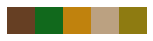

--------------------------------
Experiment 9  

Available 5 colors:


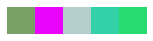

Optimum mix ratios -0.009, 0.575, 0.158 
Best difference: 4.291
Satisfied threshold after 20 of iterations!
Plot: target color, three best colors, closest mix (result)


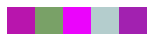

--------------------------------
Experiment 10  

Available 5 colors:


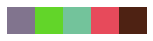

Optimum mix ratios 0.826, 0.016, 0.158 
Best difference: 14.45 
Failed to meet the threshold with the given colors. Attemps: 4004
Plot: target color, three best colors, closest mix (result)


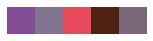

--------------------------------


In [58]:
THRESHOLD = 5.0
task_two_wrapper(10)

## Comments on the assignment

*  A possible extension is to learn the response function of the sensor
*  You may consider an explore/exploit strategy



